# Any natural number can be expressed as a product of prime numbers, $N = \Pi_{k=1}^K p_k ^{n_k}$.
#### here $p_k$ is a prime number and $n_k$ is a natural number.

## Factor a number $N=p\cdot q$, where $p, q$ are prime number.

(This is used in RSA cryptosystem)

### IDEA:

If $N$ is not a prime number, then $N$ has some interesting properties.\
Let us try to find some variable $x$ that satisfies $x^2\equiv 1 (\text{ mod }N)$. One can easily find that $x=1$ satisfies the relation for any $N$, but this is trivial and doesn't give us much hints. what about $x\equiv N-1 (\text{ mod }N)$, or $x \equiv -1 (\text{ mod }N)$?

We see that $$x^2 \equiv (N-1)^2 (\text{ mod }N) \equiv N^2 - 2N + 1(\text{ mod }N) \equiv 1 (\text{ mod }N)$$

This means $x^2 -1 \equiv 0 (\text{ mod } N)$, in other words, $N$ divides $(x+1)(x-1)$. This implies either $x+1$ shares a common factor with $N$ or $x-1$ shares a common factor with $N$.

For a number $N$ that cannot be expressed as a product of two prime numbers, this way of thining will normally bring you nowhere, but for $N$ that can is an interesting way to think about it.

If $N=p \cdot q$, wher $p$ and $q$ are both prime numbers, then $x+1$ is a prime number or $x-1$ is a prime number.

### Process:
1. pick a random number $x$ (natural number), that is coprime with $N$. Otherwise, we are done. let $k$ = gcd($N$, $x$), then $N= k\times \frac{N}{k}$.
2. if $x$ is a coprime with $N$, then compute $x^k$ for $k \in \{0, 1, 2, \ldots,r \}$ until we get $x^r \equiv 1 (\text{ mod } N)$.
3. if $r$ is even, then check $x^{r/2} \not\equiv \pm1 (\text{ mod } N)$.
4. if $x^{r/2} \not\equiv \pm1 (\text{ mod } N)$ holds, then $(x^{r/2} - 1)(x^{r/2} + 1) \equiv 0 (\text{ mod } N)$, so at least one of $(x^{r/2} - 1)$ or $(x^{r/2} + 1)$ shares a prime factor with $N$.

Classic algorithm

In [2]:
import math
from random import randint as randint

In [3]:
def product(elements):
    result = 1
    while elements:
        element = elements.pop()
        result *= element
    return result

def factor_N(m, N, visited, factors):
    if m not in visited:
        for _ in range(N):
            # find the mapped value
            candidate = m ** _ % N

            if candidate not in visited:
                # append it to visited if this is the first time finding
                visited.add(candidate)
            else:
                # if we already have the element, then the cycle starts.
                break

        period = len(visited)

        # if period has even length,
        if period % 2 == 0:
            x = (m ** int(period / 2)) % N
            x_plus  = x + 1 % N
            x_minus = x - 1 % N
            plus  = math.gcd(x_plus,  N)
            minus = math.gcd(x_minus, N)
            if plus not in factors:
                factors.add(plus)
            if minus not in factors:
                factors.add(minus)
    return factors, visited

In [4]:
N = 15
# m = 13

In [5]:
done = False
factors = set({1})
visited = set()
tried = set({1, N})
factors_product = 1

In [6]:
while factors_product != N and not done:
    m = randint(3,N-1)
    if m not in tried:
        tried.add(m)
    # check if m is a coprime with N
    if math.gcd(m,N) == 1:
        factors, visited = factor_N(m, N, visited, factors)

        # check if the product of factors equals N
        factors_product = product(factors.copy())
    if len(tried) == N:
        print("N cannot be factored as p*q where both p and q are prime")
        done = True
    
        
        
factors.remove(1)
print(factors)

{3, 5}


#### Quantum algorithm

#### Now this method is quite slow if $N$ is very large, because we have to check $x^0, x^1, \ldots, x^r$ until we get $x^r \equiv 1 (\text{ mod } N)$. Finding this period is very heavy on computing time (typically grows large as $N$ grows large).

Can we create a super-position of a set of natural numbers, then collapse the possible numbers to a unique set of $\left\{x^0(\text{ mod } N), x^1 (\text{ mod } N), \ldots, x^M (\text{ mod } N) \right\}$?

Due to non-cloning theorem, we cannot simply $\textit{copy}$ a state to another state. We will create a dummy qubits (ancilla bits) that mimics modulo operation. let $f(x) = a^x (\text{ mod } N)$, then we have this nice property:
- $f:\{0,1,\ldots,r-1\} \rightarrow \{a^0(\text{ mod } N), a^1 (\text{ mod } N), \ldots, a^{r-1}(\text{ mod } N)\}$
- $f:\{r,r+1,\ldots,2r-1\} \rightarrow \{a^0(\text{ mod } N), a^1 (\text{ mod } N), \ldots, a^{r-1}(\text{ mod } N)\}$
- and so on...

$f(x)$ is a periodic function with order $r$.

We can create an oracle that takes $\ket{x}\ket{0} \rightarrow \ket{x}\ket{f(x)}$ using the ancilla bits, and becuase the state is engangled, we can measure the possible states of $\ket{f(x)}$ which will result in $\ket{x}$ to only be a number that will result in the same remainder $\{x \mid a^x(\text{ mod } N) = q \}$, for some $q\in\{a^0(\text{ mod } N), a^1 (\text{ mod } N), \ldots, a^{r-1}(\text{ mod } N)\}$. We want to transform this basis so it starts from $0 (\text{ mod }N)$ but perserving the period (order). We can do this by applying the inverse Fourier transformation. Once we transformed it to a new basis, we can measure the state $\ket{x}$, which will output some multiple of $\frac{N}{r}$.

In [37]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [8]:
%matplotlib inline

In [9]:
N

15

In [22]:
m = 7

In [30]:
def mmod15(m, power):
    """
    Controlled multiplication by m mod 15
    Modulos function is specific to a as far as I am aware,
    but if this changes (hopefully it does), then we can implement the 
    generalized version.
    """
    if m not in [2,7,8,11,13]:
        raise ValueError("'m' must be 2,7,8,11 or 13")
    U = QuantumCircuit(n)        
    for iteration in range(power):
        if m in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if m in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if m == 11:
            U.swap(1,3)
            U.swap(0,2)
        if m in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (m, power)
    c_U = U.control()
    return c_U

In [31]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        # swap the gates
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            # perform a controlled inverse-rotation
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        # add the hardamond gate at the end
        qc.h(j)
    qc.name = "QFT†"
    return qc

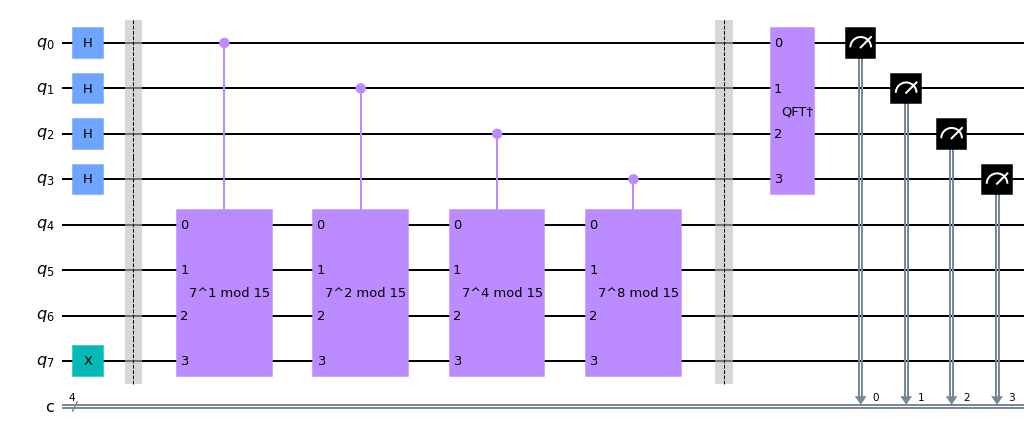

In [50]:
# find the amount of binary variables required to express N
n = len(format(N, 'b'))

# create a circuit with n qubits and n ancilla qubits
qc = QuantumCircuit(2*n,n)

# first super-position all qubits so we have a uniform distribution for all possible numbers (in binary format)
for q in range(n):
    qc.h(q)
    
# add auxiliary register
qc.x(n+3)

qc.barrier()

# Do controlled-U operations
for q in range(n):
    qc.append(mmod15(m, 2**q), 
             [q] + [i+n for i in range(4)])
qc.barrier()
# Do inverse-QFT
qc.append(qft_dagger(n), range(n))

# Measure circuit
qc.measure(range(n), range(n))
qc.draw('mpl')

In [51]:
from matplotlib import pyplot as plt

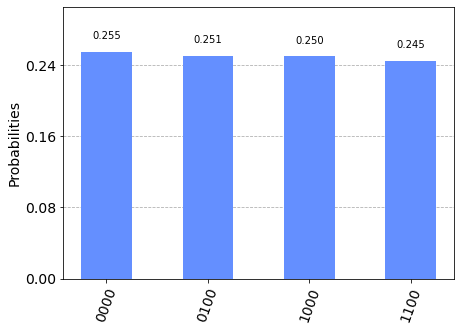

In [52]:
backend = Aer.get_backend('qasm_simulator')
shots = 10000
result = execute(qc, backend=backend, shots = shots).result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [95]:
for state, freq in counts.items():
    state = int(state,2)
    freq /= shots
    r = math.gcd(2**n,state)
    if state != 0:
        if float(int(2**n / state)) == float(2**n / state):
            r = int(2**n / state)
    print(f"state {state} has prob {round(freq, 3)}")
    print(f"gcd between 2^n and the state is {r}")
    if r % 2 == 0:
        x_plus  = int(m**(r/2)+1)
        x_minus = int(m**(r/2)-1)
        factor_plus  = math.gcd(N, x_plus)
        factor_minus = math.gcd(N, x_minus)
        print("period is even")
        
        if factor_plus != 1 and factor_minus != 1:
            print(f"N can be decomposed as {factor_plus} and {factor_minus}")
        else:
            factor = max(factor_plus, factor_minus)
            other_factor = int(N/factor)
            if factor != N:
                print(f"possible factors are: {factor} and {other_factor}")
            else:
                print(f"state {state} can't find any feasible solution, try with another state or another m")
    print()

state 12 has prob 0.245
gcd between 2^n and the state is 4
period is even
N can be decomposed as 5 and 3

state 4 has prob 0.251
gcd between 2^n and the state is 4
period is even
N can be decomposed as 5 and 3

state 0 has prob 0.255
gcd between 2^n and the state is 16
period is even
state 0 can't find any feasible solution, try with another state or another m

state 8 has prob 0.25
gcd between 2^n and the state is 2
period is even
possible factors are: 3 and 5

